# Evaluation of corrected precips

In [1]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import cmocean
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# picking my color for plots

In [3]:
a = sns.color_palette("Dark2")
a

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4)]

In [4]:
green, orange, purple, fushia, lightgreen, yellow, brown, gray = sns.color_palette("Dark2")

In [5]:
# default for line plots
sns.set_theme()
sns.set_style('dark')
sns.set_context("paper", font_scale=2.7)

## 1. Load datasets

In [6]:
erai_dir = '/archive/Raphael.Dussin/ERAinterim/nc_daily/'
erai = xr.open_mfdataset(f'{erai_dir}/*_ERAinterim_*_daily.nc',
                         combine='by_coords', chunks={'time': 24})
erai["rain"] = (erai["precip"] - erai["snow"]).clip(min=0.)

In [7]:
erai

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, time: 14610)
Coordinates:
  * lat      (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * time     (time) datetime64[ns] 1979-01-01T12:00:00 ... 2018-12-31T12:00:00
Data variables:
    precip   (time, lat, lon) float64 dask.array<chunksize=(24, 256, 512), meta=np.ndarray>
    snow     (time, lat, lon) float64 dask.array<chunksize=(24, 256, 512), meta=np.ndarray>
    rain     (time, lat, lon) float64 dask.array<chunksize=(24, 256, 512), meta=np.ndarray>

In [8]:
blend_dir ='/archive/Raphael.Dussin/ERAinterim/blend_GPCP/'
blend = xr.open_mfdataset(f'{blend_dir}/*.nc', combine='by_coords', chunks={'time': 24})

In [9]:
blend5x_dir ='/archive/Raphael.Dussin/ERAinterim/blend_GPCP_sens_5x/'
blend5x = xr.open_mfdataset(f'{blend5x_dir}/*.nc', combine='by_coords', chunks={'time': 24})

In [10]:
blend1y_dir ='/archive/Raphael.Dussin/ERAinterim/blend_GPCP_sens_1y/'
blend1y = xr.open_mfdataset(f'{blend1y_dir}/*.nc', combine='by_coords', chunks={'time': 24})

In [11]:
gpcpdir = '/archive/Raphael.Dussin/datasets/GPCPv2.3/'
gpcp = xr.open_dataset(gpcpdir + 'precip.mon.mean.nc').sel(time=slice('1979', '2018'))

In [12]:
gpcpR = xr.open_dataset('/work/Raphael.Dussin/corrected_precips/dev_forcings/precip_erainterim_correction_gpcp/GPCP_v2.3_256x512.nc')

## 2. Start cluster

In [13]:
# open labextension, scale and paste cell

## 3.1 Zonal means

In [14]:
compute_zonal_means = False

In [15]:
if compute_zonal_means:
    erai_zm = erai["rain"].mean(dim=['time', 'lon'])
    _ = erai_zm.load()
    blend_zm = blend["rain"].mean(dim=['time', 'lon'])
    _ = blend_zm.load()
    blend5x_zm = blend5x["rain"].mean(dim=['time', 'lon'])
    _ = blend5x_zm.load()
    blend1y_zm = blend1y["rain"].mean(dim=['time', 'lon'])
    _ = blend1y_zm.load()
    gpcp_zm = gpcp["precip"].mean(dim=['time', 'lon'])
    _ = gpcp_zm.load()
    gpcpR_zm = gpcpR["precip"].mean(dim=['time', 'lon'])
    _ = gpcpR_zm.load()
    
    erai_zm.to_dataset(name='rain_zmean').to_netcdf('zonal_mean_ERAinterim.nc')
    blend_zm.to_dataset(name='rain_zmean').to_netcdf('zonal_mean_BLEND.nc')
    blend5x_zm.to_dataset(name='rain_zmean').to_netcdf('zonal_mean_BLEND5X.nc')
    blend1y_zm.to_dataset(name='rain_zmean').to_netcdf('zonal_mean_BLEND1Y.nc')
    gpcp_zm.to_dataset(name='rain_zmean').to_netcdf('zonal_mean_GPCP.nc')
    gpcpR_zm.to_dataset(name='rain_zmean').to_netcdf('zonal_mean_GPCP_regridded.nc')

In [16]:
# force re-load from netcdf files
erai_zm = xr.open_dataset("zonal_mean_ERAinterim.nc")
blend_zm = xr.open_dataset("zonal_mean_BLEND.nc")
blend5x_zm = xr.open_dataset("zonal_mean_BLEND5X.nc")
blend1y_zm = xr.open_dataset("zonal_mean_BLEND1Y.nc")
gpcp_zm = xr.open_dataset("zonal_mean_GPCP.nc")
gpcpR_zm = xr.open_dataset("zonal_mean_GPCP_regridded.nc")

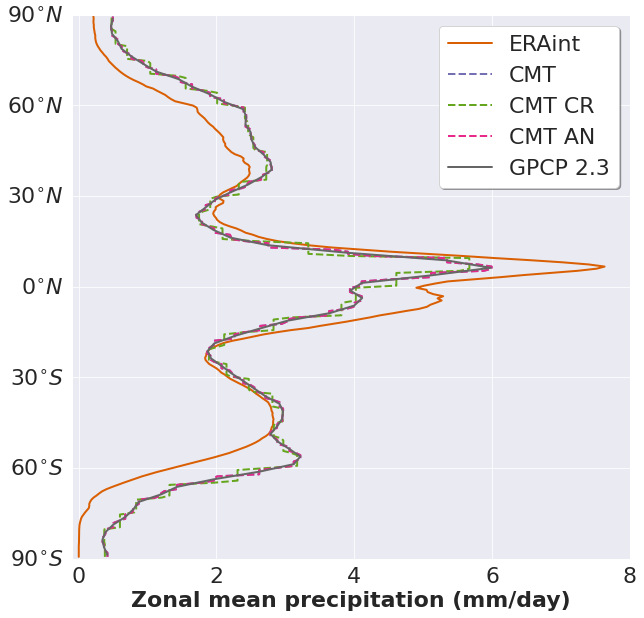

In [17]:
sns.set_theme()
sns.set_style('dark')
sns.set_context("paper", font_scale=2.7)

plt.figure(figsize=[10,10])
plt.plot(86400 * erai_zm["rain_zmean"], erai_zm['lat'], color=orange, linewidth=2, label='ERAint')
plt.plot(86400 * blend_zm["rain_zmean"], blend_zm['lat'], color=purple, linestyle='--', linewidth=2, label='CMT')
plt.plot(86400 * blend5x_zm["rain_zmean"], blend5x_zm['lat'], color=lightgreen, linestyle='--', linewidth=2, label='CMT CR')
plt.plot(86400 * blend1y_zm["rain_zmean"], blend1y_zm['lat'], color=fushia, linestyle='--', linewidth=2, label='CMT AN')
plt.plot(gpcp_zm["rain_zmean"], gpcp_zm['lat'], color=gray, linestyle='-', linewidth=2, label='GPCP 2.3')
plt.legend(fontsize=22, shadow=True, facecolor='white')
plt.xticks(fontsize=22)

plt.yticks([-90,-60,-30,0,30,60,90],
           ['$90^{\circ}S$',
            '$60^{\circ}S$',
            '$30^{\circ}S$',
            '$0^{\circ}N$',
            '$30^{\circ}N$',
            '$60^{\circ}N$',
            '$90^{\circ}N$'],
           fontsize=22)

plt.grid()
_ = plt.xlabel('Zonal mean precipitation (mm/day)', fontsize=22, weight='bold')
_= plt.ylim([-90,90])
_= plt.xlim([-0.1,8])

plt.savefig('zonal_mean.png', bbox_inches='tight')

## 3.2 Global timeseries

In [18]:
# ERA-interim

lon = erai['lon'].values
lon_bnds = np.concatenate((np.array([lon[0] -0.5 * 0.7031]), 0.5 * (lon[:-1] + lon[1:]), np.array([lon[-1] + 0.5 * 0.7031])), axis=0)

lat = erai['lat'].values
lat_bnds = np.concatenate((np.array([-90]), 0.5 * (lat[:-1] + lat[1:]), np.array([90])), axis=0)

dx = lon_bnds[1:] - lon_bnds[:-1]
dy = lat_bnds[1:] - lat_bnds[:-1]

lon2, lat2 = np.meshgrid(lon, lat)
dx2, dy2 = np.meshgrid(dx, dy)

area_erai = 4 * np.pi * np.pi *6378000 * 6378000 * dx2 * dy2 * np.cos(2*np.pi*lat2/360)
darea_erai = xr.DataArray(data=area_erai, dims=('lat', 'lon'))

# GPCP

lon = np.arange(1.25,360,2.5)
lat = np.arange(-88.75,90,2.5)
lon_b=np.arange(0,360+2.5,2.5)
lat_b=np.arange(-90,90+2.5,2.5)

dx = lon_b[1:] - lon_b[:-1]
dy = lat_b[1:] - lat_b[:-1]

lon2, lat2 = np.meshgrid(lon, lat)
dx2, dy2 = np.meshgrid(dx, dy)

area_gpcp = 4 * np.pi * np.pi *6378000 * 6378000 * dx2 * dy2 * np.cos(2*np.pi*lat2/360)
darea_gpcp = xr.DataArray(data=area_gpcp, dims=('lat', 'lon'))

In [19]:
#plt.pcolormesh(area_gpcp) ; plt.colorbar()

In [20]:
#plt.pcolormesh(area_erai) ; plt.colorbar()

In [21]:
def global_mean(da, area):
    out = (da * area).sum(dim=['lon', 'lat']) / area.sum(dim=['lon', 'lat'])
    return out

In [22]:
compute_avg_precip = False

In [23]:
if compute_avg_precip:
    # daily ERAinterim
    glopre_daily_era = 86400 * global_mean(erai["rain"], darea_erai)
    _ = glopre_daily_era.load()
    # monthly ERAinterim
    glopre_monthly_era = glopre_daily_era.resample(time="1MS").mean()
    _ = glopre_monthly_era.load()
    # monthly GPCP
    glopre_monthly_gpcp = global_mean(gpcp["precip"], darea_gpcp)
    _ = glopre_monthly_gpcp.load()
    # daily blend
    glopre_daily_blend = 86400 * global_mean(blend["rain"], darea_erai)
    _ = glopre_daily_blend.load()
    # daily blend from GPCP 5x5 degrees
    glopre_daily_blend5x = 86400 * global_mean(blend5x["rain"], darea_erai)
    _ = glopre_daily_blend5x.load()
    # daily blend from GPCP annual
    glopre_daily_blend1y = 86400 * global_mean(blend1y["rain"], darea_erai)
    _ = glopre_daily_blend1y.load()

In [24]:
if compute_avg_precip:
    glopre_daily_era.to_dataset(name='precip').to_netcdf('avg_daily_precip_erainterim.nc')
    glopre_monthly_era.to_dataset(name='precip').to_netcdf('avg_monthly_precip_erainterim.nc')
    glopre_monthly_gpcp.to_dataset(name='precip').to_netcdf('avg_monthly_precip_gpcp.nc')
    glopre_daily_blend.to_dataset(name='precip').to_netcdf('avg_daily_precip_blend.nc')
    glopre_daily_blend5x.to_dataset(name='precip').to_netcdf('avg_daily_precip_blend5x.nc')
    glopre_daily_blend1y.to_dataset(name='precip').to_netcdf('avg_daily_precip_blend1y.nc')

In [25]:
glopre_daily_era = xr.open_dataset('avg_daily_precip_erainterim.nc')['precip']
glopre_monthly_era = xr.open_dataset('avg_monthly_precip_erainterim.nc')['precip']
glopre_monthly_gpcp = xr.open_dataset('avg_monthly_precip_gpcp.nc')['precip']
glopre_daily_blend = xr.open_dataset('avg_daily_precip_blend.nc')['precip']
glopre_daily_blend5x = xr.open_dataset('avg_daily_precip_blend5x.nc')['precip']
glopre_daily_blend1y = xr.open_dataset('avg_daily_precip_blend1y.nc')['precip']

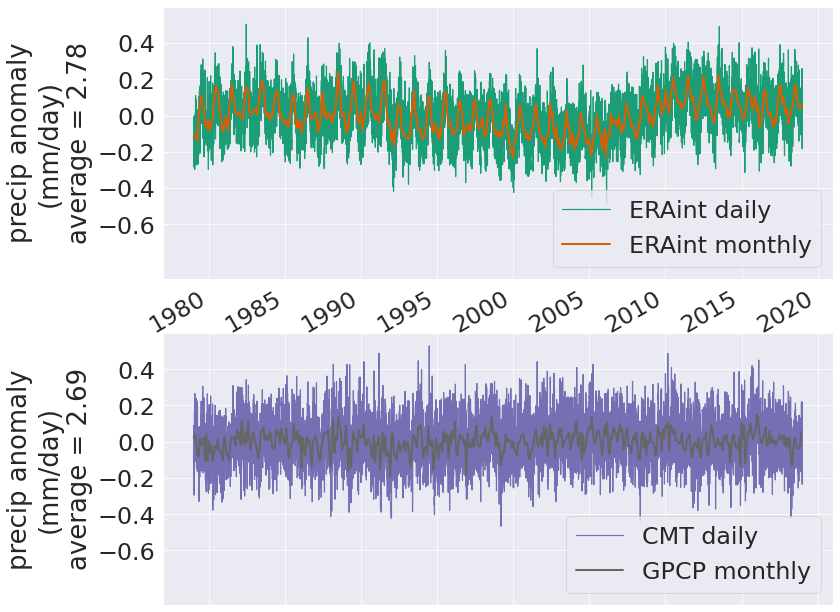

In [26]:
sns.set_theme()
sns.set_style('dark')
sns.set_context("paper", font_scale=2.7)

fig, axs = plt.subplots(2, figsize=[12,11])
mean_era = glopre_daily_era.mean(dim='time')
cmean_era = "{:.2f}".format(mean_era.values)
(glopre_daily_era - mean_era).plot(ax=axs[0], color=green, label='ERAint daily')
(glopre_monthly_era - mean_era).plot(ax=axs[0], color=orange, linewidth=2, label='ERAint monthly')
axs[0].set_xlabel("")
axs[0].set_yticks([-0.6, -0.4, -0.2, 0., 0.2, 0.4])
axs[0].set_ylim([-0.9,0.6])
axs[0].legend(loc=4)
axs[0].set_ylabel(f"precip anomaly\n(mm/day)\naverage = {cmean_era}")
axs[0].grid()

mean_gpcp = glopre_monthly_gpcp.mean(dim='time')
cmean_gpcp = "{:.2f}".format(mean_gpcp.values)
(glopre_daily_blend - mean_gpcp).plot(ax=axs[1], color=purple, label='CMT daily')
(glopre_monthly_gpcp - mean_gpcp).plot(ax=axs[1], color=gray, linewidth=2, label='GPCP monthly')
axs[1].set_xticklabels([])
axs[1].set_yticks([-0.6, -0.4, -0.2, 0., 0.2, 0.4])
axs[1].set_ylim([-0.9,0.6])
axs[1].legend(loc=4)
axs[1].set_xlabel("")
axs[1].set_ylabel(f"precip anomaly\n(mm/day)\naverage = {cmean_gpcp}")
axs[1].grid()

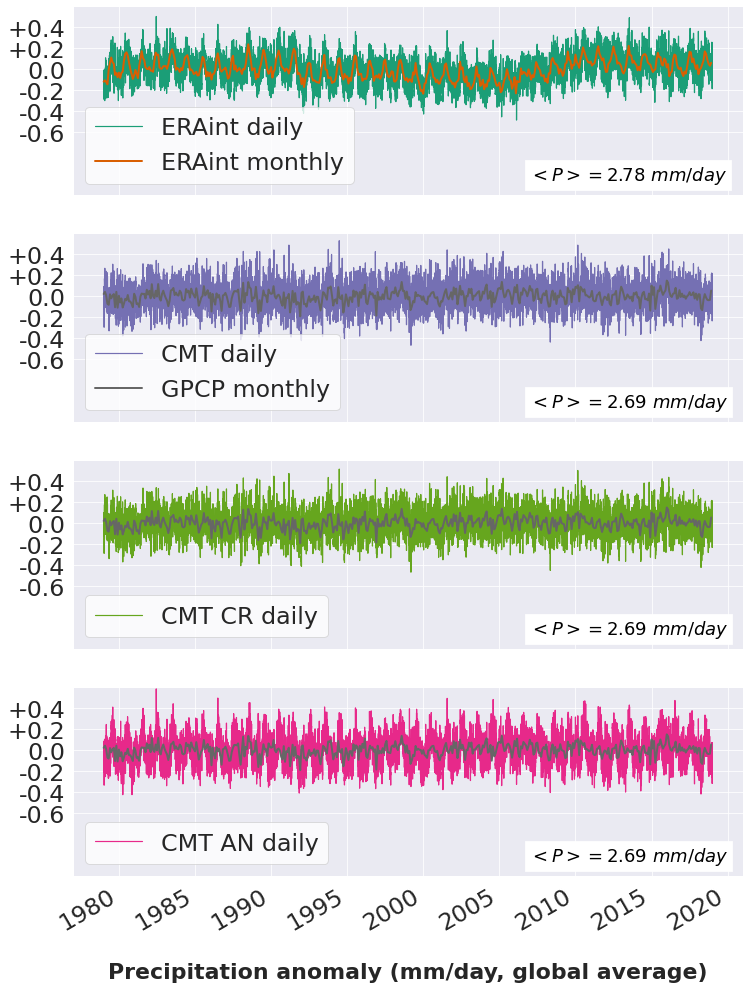

In [27]:
sns.set_theme()
sns.set_style('dark')
sns.set_context("paper", font_scale=2.7)

fig, axs = plt.subplots(4, figsize=[12,16])
mean_era = glopre_daily_era.mean(dim='time')
cmean_era = "{:.2f}".format(mean_era.values)
(glopre_daily_era - mean_era).plot(ax=axs[0], color=green, label='ERAint daily')
(glopre_monthly_era - mean_era).plot(ax=axs[0], color=orange, linewidth=2, label='ERAint monthly')

mean_gpcp = glopre_monthly_gpcp.mean(dim='time')
cmean_gpcp = "{:.2f}".format(mean_gpcp.values)
(glopre_daily_blend - mean_gpcp).plot(ax=axs[1], color=purple, label='CMT daily')
(glopre_monthly_gpcp - mean_gpcp).plot(ax=axs[1], color=gray, linewidth=2, label='GPCP monthly')

(glopre_daily_blend5x- mean_gpcp).plot(ax=axs[2], color=lightgreen, label='CMT CR daily')
(glopre_monthly_gpcp - mean_gpcp).plot(ax=axs[2], color=gray, linewidth=2)

(glopre_daily_blend1y - mean_gpcp).plot(ax=axs[3], color=fushia, label='CMT AN daily')
(glopre_monthly_gpcp - mean_gpcp).plot(ax=axs[3], color=gray, linewidth=2)


for k in range(3):
    axs[k].set_xticklabels([])

for k in range(4):
    axs[k].set_xlabel("")
    axs[k].set_ylabel("")
    axs[k].set_yticks([-0.6, -0.4, -0.2, 0., 0.2, 0.4])
    axs[k].set_yticklabels(['-0.6', '-0.4', '-0.2', '0.0', '+0.2', '+0.4'])
    axs[k].set_ylim([-1.2,0.6])
    axs[k].grid()
    axs[k].legend(loc=3, facecolor='white')
    
axs[0].text(0.68, 0.05, '$<P> = 2.78~mm/day$',
            verticalalignment='bottom',
            horizontalalignment='left',
            transform=axs[0].transAxes,
            bbox={'facecolor': 'white'},
            color='black', fontsize=18)

for k in range(1,4):
    axs[k].text(0.68, 0.05, '$<P> = 2.69~mm/day$',
                verticalalignment='bottom',
                horizontalalignment='left',
                transform=axs[k].transAxes,
                bbox={'facecolor': 'white'},
                color='black', fontsize=18)
    
plt.xlabel('\nPrecipitation anomaly (mm/day, global average)', fontsize=22, weight='bold')
plt.savefig('global_timeseries.png', bbox_inches='tight')

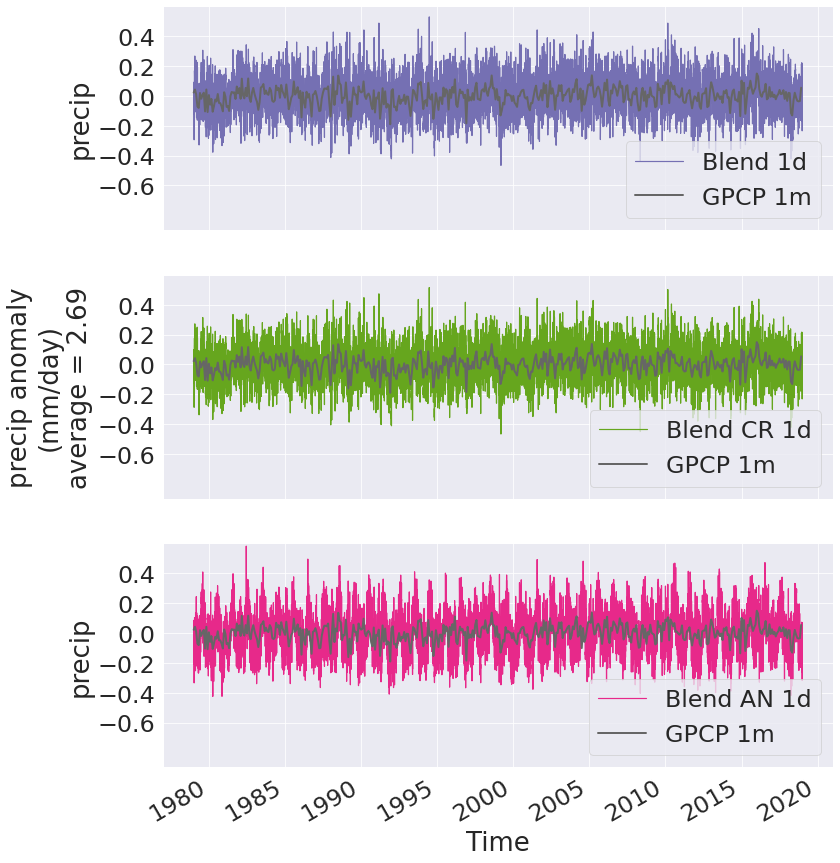

In [28]:
fig, axs = plt.subplots(3, figsize=[12,14])
mean_gpcp = glopre_monthly_gpcp.mean(dim='time')
cmean_gpcp = "{:.2f}".format(mean_gpcp.values)
(glopre_daily_blend - mean_gpcp).plot(ax=axs[0], color=purple, label='Blend 1d')
(glopre_monthly_gpcp - mean_gpcp).plot(ax=axs[0], color=gray, linewidth=2, label='GPCP 1m')

(glopre_daily_blend5x- mean_gpcp).plot(ax=axs[1], color=lightgreen, label='Blend CR 1d')
(glopre_monthly_gpcp - mean_gpcp).plot(ax=axs[1], color=gray, linewidth=2, label='GPCP 1m')

(glopre_daily_blend1y - mean_gpcp).plot(ax=axs[2], color=fushia, label='Blend AN 1d')
(glopre_monthly_gpcp - mean_gpcp).plot(ax=axs[2], color=gray, linewidth=2, label='GPCP 1m')

_ = axs[0].set_xticklabels([])
_ = axs[1].set_xticklabels([])

_ = axs[0].set_xticklabels([])
_ = axs[1].set_xticklabels([])

axs[0].set_yticks([-0.6, -0.4, -0.2, 0., 0.2, 0.4])
axs[1].set_yticks([-0.6, -0.4, -0.2, 0., 0.2, 0.4])
axs[2].set_yticks([-0.6, -0.4, -0.2, 0., 0.2, 0.4])

axs[0].set_ylim([-0.9,0.6])
axs[1].set_ylim([-0.9,0.6])
axs[2].set_ylim([-0.9,0.6])

_ = axs[0].legend(loc=4)
_ = axs[1].legend(loc=4)
_ = axs[2].legend(loc=4)

_ = axs[0].set_xlabel("")
_ = axs[1].set_xlabel("")

_ = axs[1].set_ylabel(f"precip anomaly\n(mm/day)\naverage = {cmean_gpcp}")

_ = axs[0].grid()
_ = axs[1].grid()
_ = axs[2].grid()

## 3.3 Variances

In [29]:
compute_variance = False

In [30]:
if compute_variance:
    variance_erai = erai["rain"].var(dim='time')
    _ = variance_erai.load()
    variance_erai.to_dataset(name="var_pre").to_netcdf("variance_precip_erai.nc")

if compute_variance:
    variance_blend = blend["rain"].var(dim='time')
    _ = variance_blend.load()
    variance_blend.to_dataset(name="var_pre").to_netcdf("variance_precip_blend.nc")

if compute_variance:
    variance_blend5x = blend5x["rain"].var(dim='time')
    _ = variance_blend5x.load()
    variance_blend5x.to_dataset(name="var_pre").to_netcdf("variance_precip_blend5x.nc")

if compute_variance:
    variance_blend1y = blend1y["rain"].var(dim='time')
    _ = variance_blend1y.load()
    variance_blend1y.to_dataset(name="var_pre").to_netcdf("variance_precip_blend1y.nc")

if compute_variance:
    variance_gpcp = gpcp["precip"].var(dim='time')
    _ = variance_gpcp.load()
    variance_gpcp.to_dataset(name="var_pre").to_netcdf("variance_precip_gpcp.nc")

In [31]:
variance_erai = xr.open_dataset("variance_precip_erai.nc")
variance_blend = xr.open_dataset("variance_precip_blend.nc")
variance_blend5x = xr.open_dataset("variance_precip_blend5x.nc")
variance_blend1y = xr.open_dataset("variance_precip_blend1y.nc")
variance_gpcp = xr.open_dataset("variance_precip_gpcp.nc")

Text(0, 0.5, 'Latitude (deg)')

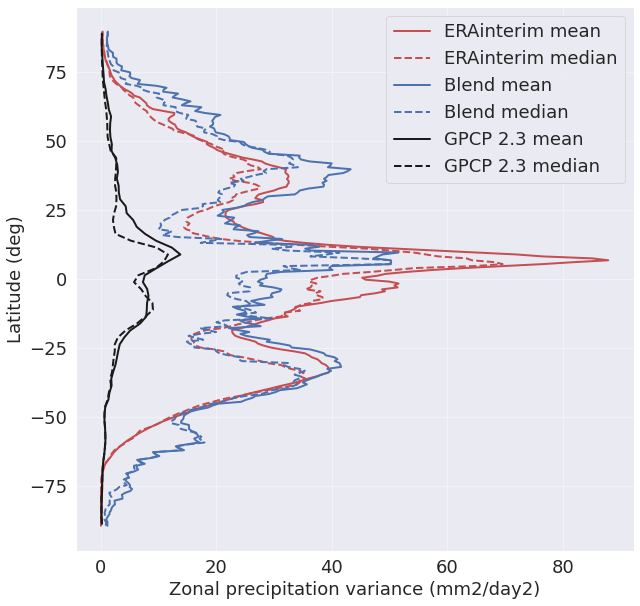

In [32]:
plt.figure(figsize=[10,10])

plt.plot(86400*86400*variance_erai["var_pre"].mean(dim='lon'), variance_erai['lat'], 'r', linewidth=2, label='ERAinterim mean')
plt.plot(86400*86400*variance_erai["var_pre"].median(dim='lon'), variance_erai['lat'], 'r--', linewidth=2, label='ERAinterim median')
plt.plot(86400*86400*variance_blend["var_pre"].mean(dim='lon'), variance_blend['lat'], 'b', linewidth=2, label='Blend mean')
plt.plot(86400*86400*variance_blend["var_pre"].median(dim='lon'), variance_blend['lat'], 'b--', linewidth=2, label='Blend median')
plt.plot(variance_gpcp["var_pre"].mean(dim='lon'), variance_gpcp['lat'], 'k', linewidth=2, label='GPCP 2.3 mean')
plt.plot(variance_gpcp["var_pre"].median(dim='lon'), variance_gpcp['lat'], 'k--', linewidth=2, label='GPCP 2.3 median')

plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(alpha=0.5)
plt.xlabel('Zonal precipitation variance (mm2/day2)', fontsize=18)
plt.ylabel('Latitude (deg)', fontsize=18)
#plt.savefig('zonal_variance.png', bbox_inches='tight')

Text(0, 0.5, 'Latitude (deg)')

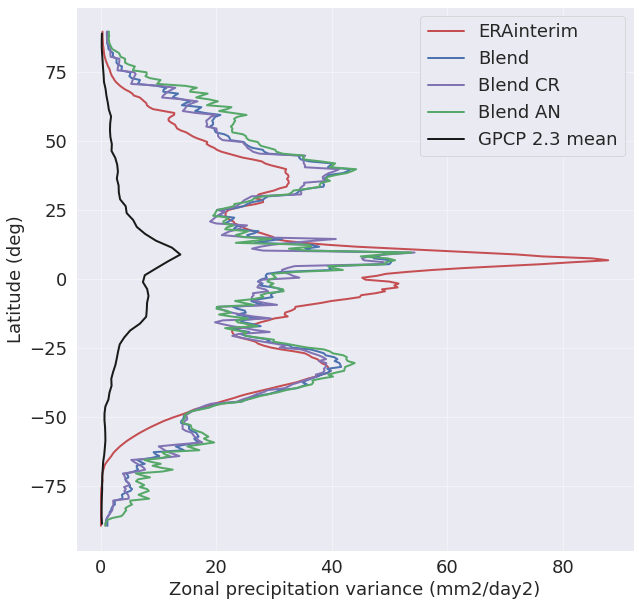

In [33]:
plt.figure(figsize=[10,10])

plt.plot(86400*86400*variance_erai["var_pre"].mean(dim='lon'), variance_erai['lat'], 'r', linewidth=2, label='ERAinterim')
#plt.plot(86400*86400*variance_erai["var_pre"].median(dim='lon'), variance_erai['lat'], 'r--', linewidth=2, label='ERAinterim median')
plt.plot(86400*86400*variance_blend["var_pre"].mean(dim='lon'), variance_blend['lat'], 'b', linewidth=2, label='Blend')
plt.plot(86400*86400*variance_blend5x["var_pre"].mean(dim='lon'), variance_blend5x['lat'], 'm', linewidth=2, label='Blend CR')
plt.plot(86400*86400*variance_blend1y["var_pre"].mean(dim='lon'), variance_blend1y['lat'], 'g', linewidth=2, label='Blend AN')

#plt.plot(86400*86400*variance_blend["var_pre"].median(dim='lon'), variance_blend['lat'], 'b--', linewidth=2, label='Blend median')
plt.plot(variance_gpcp["var_pre"].mean(dim='lon'), variance_gpcp['lat'], 'k', linewidth=2, label='GPCP 2.3 mean')
#plt.plot(variance_gpcp["var_pre"].median(dim='lon'), variance_gpcp['lat'], 'k--', linewidth=2, label='GPCP 2.3 median')

plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(alpha=0.5)
plt.xlabel('Zonal precipitation variance (mm2/day2)', fontsize=18)
plt.ylabel('Latitude (deg)', fontsize=18)
#plt.savefig('zonal_variance.png', bbox_inches='tight')

In [34]:
varplt_blend = 86400*86400*variance_blend["var_pre"]

In [35]:
varplt_blend5x = 86400*86400*variance_blend5x["var_pre"]

In [36]:
varplt_blend1y = 86400*86400*variance_blend1y["var_pre"]

In [37]:
varplt_erai = 86400*86400*variance_erai["var_pre"]

In [38]:
varplt_gpcp = variance_gpcp["var_pre"]

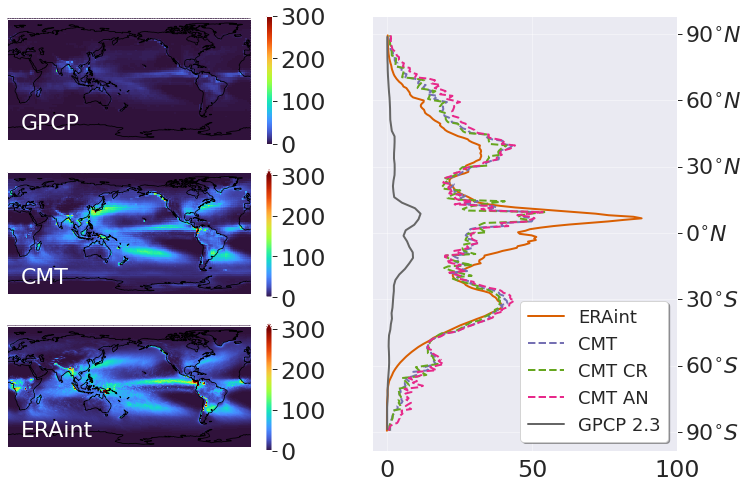

In [39]:
sns.set_theme()
sns.set_style('dark')
sns.set_context("paper", font_scale=2.7)

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(12, 8),
                        subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
gs = axs[1, 1].get_gridspec()

# remove the underlying axes
for ax in axs[0:, -1]:
    ax.remove()
axbig = fig.add_subplot(gs[0:, -1])

cbar_kwargs={'ticks': [0,100,200,300]}

ax0 = axs[0,0]
ax0.coastlines()
C0 = ax0.pcolormesh(varplt_gpcp.lon, varplt_gpcp.lat, varplt_gpcp, vmin=0, vmax=300, cmap='turbo', transform=ccrs.PlateCarree())
varplt_gpcp.plot(ax=ax0, vmin=0, vmax=300,
                 add_labels=False, cbar_kwargs=cbar_kwargs,
                 cmap='turbo', transform=ccrs.PlateCarree())

ax0.text(-160, -80, 'GPCP',
        verticalalignment='bottom',
         horizontalalignment='left',
        color='white', fontsize=22)

ax1 = axs[1,0]
ax1.coastlines()
varplt_blend.plot(ax=ax1, vmin=0, vmax=300,
                 add_labels=False, cbar_kwargs=cbar_kwargs,
                 cmap='turbo', transform=ccrs.PlateCarree())
ax1.text(-160, -80, 'CMT',
        verticalalignment='bottom',
         horizontalalignment='left',
        color='white', fontsize=22)

ax2 = axs[2,0]
ax2.coastlines()
varplt_erai.plot(ax=ax2, vmin=0, vmax=300,
                 add_labels=False, cbar_kwargs=cbar_kwargs,
                 cmap='turbo', transform=ccrs.PlateCarree())
ax2.text(-160, -80, 'ERAint',
        verticalalignment='bottom',
         horizontalalignment='left',
         color='white', fontsize=22)

axbig.plot(86400*86400*variance_erai["var_pre"].mean(dim='lon'), variance_erai['lat'], color=orange, linestyle='-', linewidth=2, label='ERAint')
axbig.plot(86400*86400*variance_blend["var_pre"].mean(dim='lon'), variance_blend['lat'], color=purple, linestyle='--', linewidth=2, label='CMT')
axbig.plot(86400*86400*variance_blend5x["var_pre"].mean(dim='lon'), variance_blend5x['lat'], color=lightgreen, linestyle='--', linewidth=2, label='CMT CR')
axbig.plot(86400*86400*variance_blend1y["var_pre"].mean(dim='lon'), variance_blend1y['lat'], color=fushia, linestyle='--', linewidth=2, label='CMT AN')
axbig.plot(variance_gpcp["var_pre"].median(dim='lon'), variance_gpcp['lat'], color=gray, linestyle='-', linewidth=2, label='GPCP 2.3')

axbig.legend(fontsize=18, loc=4,shadow=True, facecolor='white')
axbig.grid(alpha=0.5)
axbig.set_yticks([-90,-60,-30,0,30,60,90])
axbig.set_yticklabels(['$90^{\circ}S$',
                       '$60^{\circ}S$',
                       '$30^{\circ}S$',
                        '$0^{\circ}N$',
                        '$30^{\circ}N$',
                        '$60^{\circ}N$',
                        '$90^{\circ}N$'], fontsize=22)

axbig.set_xlim([-5,100])
axbig.yaxis.tick_right()
axbig.yaxis.set_label_position("right")
plt.savefig('variance.png', bbox_inches='tight')

Text(-160, -80, 'CMT AN')

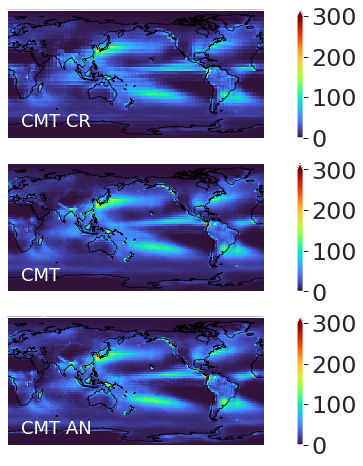

In [40]:
cbar_kwargs={'ticks': [0,100,200,300]}

fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
ax0 = axs[0]
ax0.coastlines()
varplt_blend5x.plot(ax=ax0, vmin=0, vmax=300,
                    add_labels=False, cbar_kwargs=cbar_kwargs,
                    cmap='turbo', transform=ccrs.PlateCarree())

ax1 = axs[1]
ax1.coastlines()
varplt_blend.plot(ax=ax1, vmin=0, vmax=300,
                 add_labels=False, cbar_kwargs=cbar_kwargs,
                 cmap='turbo', transform=ccrs.PlateCarree())

ax2 = axs[2]
ax2.coastlines()
varplt_blend1y.plot(ax=ax2, vmin=0, vmax=300,
                    add_labels=False, cbar_kwargs=cbar_kwargs,
                    cmap='turbo', transform=ccrs.PlateCarree())


ax0.text(-160, -80, 'CMT CR',
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=18)
ax1.text(-160, -80, 'CMT',
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=18)
ax2.text(-160, -80, 'CMT AN',
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=18)

In [41]:
#cluster.close()
#client.close()

## 3.4 Snapshot Atlantic storm

In [42]:
data_blend = (86400 * blend['rain']).isel(time=31).sel(lon=slice(280,320), lat=slice(20,50))

In [43]:
data_blend5x = (86400 * blend5x['rain']).isel(time=31).sel(lon=slice(280,320), lat=slice(20,50))

In [44]:
data_blend1y = (86400 * blend1y['rain']).isel(time=31).sel(lon=slice(280,320), lat=slice(20,50))

In [45]:
data_erai = (86400 * erai['rain']).isel(time=31).sel(lon=slice(280,320), lat=slice(20,50))

In [46]:
# create corners for pcolormesh
lon = data_erai['lon'].values
lon_bnds = np.concatenate((np.array([lon[0] -0.5 * 0.7031]), 0.5 * (lon[:-1] + lon[1:]), np.array([lon[-1] + 0.5 * 0.7031])), axis=0)

lat = data_erai['lat'].values
lat_bnds = np.concatenate((np.array([lat[0] -0.5 * 0.7031]), 0.5 * (lat[:-1] + lat[1:]), np.array([lat[-1] + 0.5 * 0.7031])), axis=0)


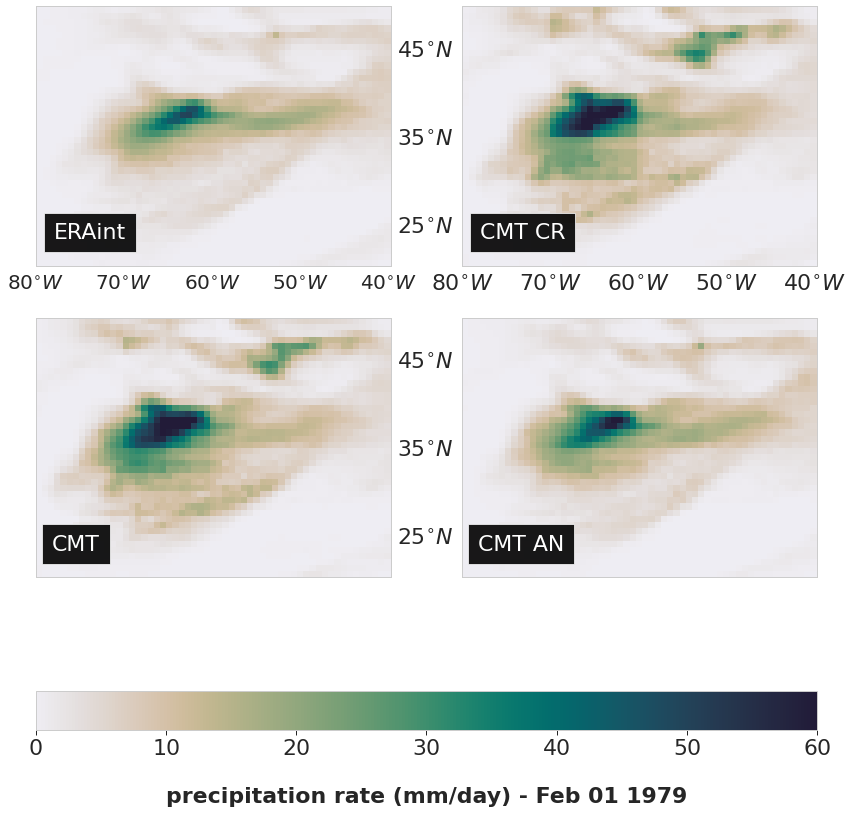

In [47]:
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=2.7)

latlabels = ['$25^{\circ}N$', '$35^{\circ}N$', '$45^{\circ}N$']
lonlabels = ['$80^{\circ}W$', '$70^{\circ}W$', '$60^{\circ}W$', '$50^{\circ}W$', '$40^{\circ}W$']

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=[14,14])

ax0 = axs[0,0]
C0 = ax0.pcolormesh(lon_bnds, lat_bnds, data_erai.values.clip(min=0, max=60), vmin=0, vmax=60, cmap=cmocean.cm.rain)
ax0.set_xticks([280, 290, 300, 310, 320])
ax0.set_xticklabels(labels=lonlabels, fontsize=20)
ax0.set_yticks([])

ax1 = axs[1,0]
C1 = ax1.pcolormesh(lon_bnds, lat_bnds, data_blend.values.clip(min=0, max=60), vmin=0, vmax=60, cmap=cmocean.cm.rain)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = axs[0,1]
C2 = ax2.pcolormesh(lon_bnds, lat_bnds, data_blend5x.values.clip(min=0, max=60), vmin=0, vmax=60, cmap=cmocean.cm.rain)
ax2.set_xticks([280, 290, 300, 310, 320])
ax2.set_xticklabels(labels=lonlabels, fontsize=22)
ax2.set_yticks([25, 35, 45])
ax2.set_yticklabels(labels=latlabels, fontsize=22)

ax3 = axs[1,1]
C3 = ax3.pcolormesh(lon_bnds, lat_bnds, data_blend1y.values.clip(min=0, max=60), vmin=0, vmax=60, cmap=cmocean.cm.rain)
ax3.set_xticks([])
ax3.set_yticks([25, 35, 45])
ax3.set_yticklabels(labels=latlabels, fontsize=22)


cbar = fig.colorbar(C0, ax=axs, orientation='horizontal', fraction=.1)
cbar.ax.tick_params(labelsize=22)
cbar.set_label(label='\nprecipitation rate (mm/day) - Feb 01 1979', size=22, weight='bold')


ax0.text(282, 23, 'ERAint',
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=22,
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10})
ax1.text(282, 23, 'CMT',
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=22,
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10})
ax2.text(282, 23, 'CMT CR',
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=22,
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10})
ax3.text(282, 23, 'CMT AN',
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=22,
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10})


plt.savefig('snapshot.png', bbox_inches='tight')